In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

def plt_eig(ax, nb_vec, eig_vec, title):
    # nb_vec : vector to neighbor atoms
    # eig_vec : eigen vector of given atoms
    xs, ys, zs = nb_vec[0, :], nb_vec[1, :], nb_vec[2, :]
    mean_x = np.mean(xs)
    mean_y = np.mean(ys)
    mean_z = np.mean(zs)


    ax.plot(xs, ys, zs, 'o', markersize=8, color='green', alpha=0.2)
    ax.plot([mean_x], [mean_y], [mean_z], 'o', markersize=20, color='k', alpha=0.5)

    colors = ['r', 'g', 'b']
    for v, color in zip(eig_vec.T, colors):
        a = Arrow3D([mean_x, v[0]], [mean_y, v[1]], [mean_z, v[2]], mutation_scale=20, lw=3, arrowstyle="-|>", color=color)
        ax.add_artist(a)
        
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    ax.set_title(title)

    # Create cubic bounding box to simulate equal aspect ratio
    range_x = xs.max() - xs.min()
    range_y = ys.max() - ys.min()
    range_z = zs.max() - zs.min()
    
    max_range = np.array([range_x, range_y, range_z]).max()
    Xb = 0.5 * max_range * np.mgrid[-1:2:2, -1:2:2, -1:2:2][0].flatten() + 0.5 * (xs.max() + xs.min())
    Yb = 0.5 * max_range * np.mgrid[-1:2:2, -1:2:2, -1:2:2][1].flatten() + 0.5 * (ys.max() + ys.min())
    Zb = 0.5 * max_range * np.mgrid[-1:2:2, -1:2:2, -1:2:2][2].flatten() + 0.5 * (zs.max() + zs.min())

    # Comment or uncomment following both lines to test the fake bounding box:
    for xb, yb, zb in zip(Xb, Yb, Zb):
        ax.plot([xb], [yb], [zb], 'w')
    
    return ax        

import seaborn as sns        
sns.set_style("whitegrid")
sns.set_palette("bright")
sns.set_context("talk")

debugmode = 1


#	X range= 0.00 ~ 16.78,	x length= 17.78
#	Y range= 0.00 ~ 16.78,	y length= 17.78
#	Z range= 0.00 ~ 18.23,	z length= 19.23
threshold vector length = 6.20713
vec_x= 1.5210857142857142


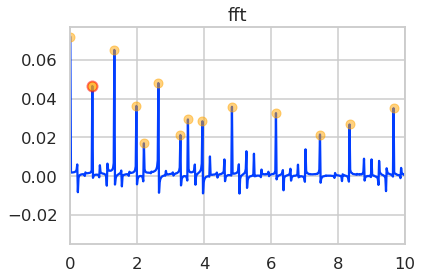

vec_y = 1.5210857142857142


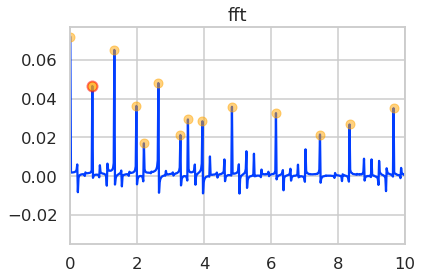

vec_z = 1.5272903225806453


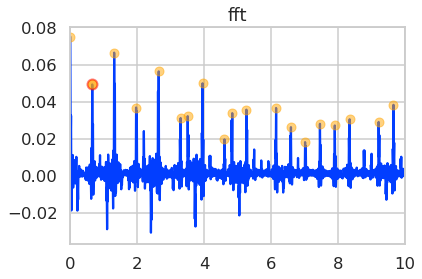

f_radius = 2.638184836181243
number of surface atoms =  272


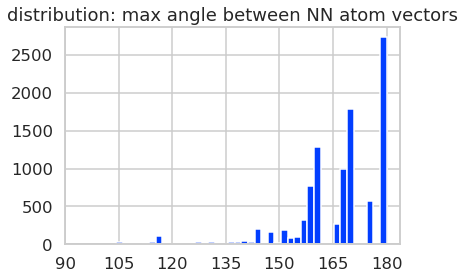

In [17]:
import pandas as pd
import numpy as np
import os, copy
from sys import argv
import matplotlib.pyplot as plt

PATH_voro = "./voro++-0.4.6/src"
PATH_vasp = "./vasp"
PATH_out = "./vasp_surface"

### debug mode parameter: working only in debugmode
class debugmode:
    filename = "CoSb3_001_2x2_2L_20A.vasp"
    theta = 105  # criteria for 2NN surface atom detection
    
    target_atom = 66  # atom to be investigated deeply in debugmode
    nb_vec = 0  # vectors from target atom to the neighbors
    eig_vec = 0  # eigenvectors
    transformed = 0 # nb_vec after PCA transformation
    transformed_eigvec = 0 # eigenvectors of after PCA transformation
    
    
    plot_hist = 1
    plot_pos = 0
    plot_fft = 1
    plot_eigenvector = 1


### code
class POSCAR:
    theta = 105          # surface threshold in degree
    lentol = 0.01        # length tolerance. "(1 + lentol) * maxveclen" is regarded as the surface criteria
    ninfile = ''
    header = []
    lat_vec = []
    atom_species = []
    atom_numbers = []
    total_atom = 0
    nb_atoms_list = []
    
    xmin = np.inf
    xmax = -np.inf
    ymin = np.inf
    ymax = -np.inf
    zmin = np.inf
    zmax = -np.inf
    xlen = -1
    ylen = -1
    zlen = -1
    
    maxveclen = 0
    
    f_radius = 0
    
    data = pd.DataFrame(columns=['xcoord', 'ycoord', 'zcoord', 'atom_num',
                                 'mat_org', 'matnum_org', 'surf_flag', 'num_neighbor',
                                 'nb_vector_x', 'nb_vector_y', 'nb_vector_z', 'nb_vector_sum', 'polar_delta'])


def input_check():
    if debugmode:
        POSCAR.theta = debugmode.theta
        
    else:
        if len(argv) != 2 and len(argv) != 3:
            print "\n###\tError!!\t###"
            print "#"
            print "#\tUSAGE1: > python3 SurfaceExtraction.py vasp_file_name.vasp"
            print "#\t      ex) python3 SurfaceExtraction.py SiO2.vasp"
            print "#\n"
            print "#\tUSAGE2: > python3 SurfaceExtraction.py vasp_file_name.vasp surface_threshold_angle_in_degree"
            print "#        ex) python3 SurfaceExtraction.py SiO2.vasp 60"
            exit(1)
        if len(argv) == 3:
            POSCAR.theta = float(argv[2])
            print 'surface threshold angle = ', POSCAR.theta

        

def readPOSCAR():
    POSCAR.surf_th = 360-POSCAR.theta       # surface threshold in degree (inside material)
    
    if debugmode:
        filename = debugmode.filename
    else:
        filename = argv[1]
    
    POSCAR.ninfile = os.path.join(PATH_vasp, filename)
    line_list = [line.strip() for line in open(POSCAR.ninfile)]
    compact_line = [x for x in line_list if x != []]

    coordi_start = 0
    for line in compact_line:
        if len(line.lower()) != 0:
            if line.lower()[0] == 'd' or line.lower()[0] == 'c':
                coordi_type = line.lower()
                coordi_start = compact_line.index(line) + 1
    
    POSCAR.header = line_list[0:coordi_start]

    for i in range(3):
        POSCAR.lat_vec.append([float(x) for x in compact_line[2+i].split()])
    
    if coordi_start == 8:
        POSCAR.atom_species = compact_line[coordi_start - 3].split()
        POSCAR.atom_numbers = [int(x) for x in compact_line[coordi_start - 2].split()]
    else:
        POSCAR.atom_species = compact_line[coordi_start - 4].split()
        POSCAR.atom_numbers = [int(x) for x in compact_line[coordi_start - 3].split()]
    
    POSCAR.total_atom = sum(POSCAR.atom_numbers)
    
    
    scale_factor = float(compact_line[1])
    matnum = 0
    for i in range(POSCAR.total_atom):
        raw_coords = [float(x) for x in compact_line[coordi_start + i].split()[0:3]]
        x_fact = raw_coords[0] * POSCAR.lat_vec[0][0] + raw_coords[1] * POSCAR.lat_vec[1][0]  + raw_coords[2] * POSCAR.lat_vec[2][0]
        y_fact = raw_coords[0] * POSCAR.lat_vec[0][1] + raw_coords[1] * POSCAR.lat_vec[1][1]  + raw_coords[2] * POSCAR.lat_vec[2][1]
        z_fact = raw_coords[0] * POSCAR.lat_vec[0][2] + raw_coords[1] * POSCAR.lat_vec[1][2]  + raw_coords[2] * POSCAR.lat_vec[2][2]

        if coordi_type[0] == 'd':
            coords = [x_fact * scale_factor, y_fact * scale_factor, z_fact * scale_factor]
        else:
            coords = raw_coords
        
        if coords[0] < POSCAR.xmin:
            POSCAR.xmin = coords[0]
        if coords[0] > POSCAR.xmax:
            POSCAR.xmax = coords[0]
        if coords[1] < POSCAR.ymin:
            POSCAR.ymin = coords[1]
        if coords[1] > POSCAR.ymax:
            POSCAR.ymax = coords[1]
        if coords[2] < POSCAR.zmin:
            POSCAR.zmin = coords[2]
        if coords[2] > POSCAR.zmax:
            POSCAR.zmax = coords[2]
        
            
        POSCAR.data.at[i, 'xcoord'] = coords[0]
        POSCAR.data.at[i, 'ycoord'] = coords[1]
        POSCAR.data.at[i, 'zcoord'] = coords[2]
        POSCAR.data.at[i, 'atom_num'] = int(i+1)
        if i >= sum(POSCAR.atom_numbers[0:matnum+1]):
            matnum += 1
        POSCAR.data.at[i, 'mat_org'] = POSCAR.atom_species[matnum]
        POSCAR.data.at[i, 'matnum_org'] = POSCAR.atom_numbers[matnum]
        POSCAR.data.at[i, 'surf_flag'] = "internal"
    
    POSCAR.xlen = POSCAR.xmax - POSCAR.xmin + 1 # +1 is to avoid atom overlapping
    POSCAR.ylen = POSCAR.ymax - POSCAR.ymin + 1
    POSCAR.zlen = POSCAR.zmax - POSCAR.zmin + 1

    print '\n#\tX range= %.2f ~ %.2f,\tx length= %.2f' %(POSCAR.xmin, POSCAR.xmax, POSCAR.xlen)
    print '#\tY range= %.2f ~ %.2f,\ty length= %.2f' %(POSCAR.ymin, POSCAR.ymax, POSCAR.ylen)
    print '#\tZ range= %.2f ~ %.2f,\tz length= %.2f' %(POSCAR.zmin, POSCAR.zmax, POSCAR.zlen)

    return POSCAR.data


def peakfind(X, Y, X_init, Y_final):
    peakind = []
    pos = X_init
    while X[pos] <= Y_final:
        kernal = [pos-3, pos-2, pos-1, pos, pos+1, pos+2, pos+3]
        if pos-3 < 0:
            kernal[0] = pos+3
        if pos-2 < 0:
            kernal[1] = pos+2
        if pos-1 < 0:
            kernal[2] = pos+1
        
        y1 = Y[kernal[0]]
        y2 = Y[kernal[1]]
        y3 = Y[kernal[2]]
        y4 = Y[kernal[3]]
        y5 = Y[kernal[4]]
        y6 = Y[kernal[5]]
        y7 = Y[kernal[6]]
        y_1 = [y1, y2, y3, y4, y5, y6, y7]
        

        if (y4 == max(y_1)) and (y4 >= 0.2 * Y[0]):
            x_2 = np.arange(pos*2-2, pos*2+3)
            y_2 = np.zeros(5)
            for i in range(5):
                y_2[i] = Y[x_2[i]]
            if y_2.max() > 0:
                peakind.append(pos)

        pos += 1
        
    if len(peakind) < 2:
        peakind.append(0)
        peakind.append(0)
    return peakind

def selfEvaluation(POSCAR = POSCAR):
    if os.path.isfile('voro_input_single') is True:
        os.remove('voro_input_single')
    if os.path.isfile('voro_input_single.vol') is True:
        os.remove('voro_input_single.vol')
    
    noutfile = 'voro_input_single'
    outfile = open(noutfile, 'w')
    
    for i in range(POSCAR.total_atom):
        outfile.write(str(i+1)+'\t'+str(POSCAR.data.xcoord.loc[i])
                      +'\t'+str(POSCAR.data.ycoord.loc[i])
                      +'\t'+str(POSCAR.data.zcoord.loc[i])+'\n')
    
    outfile.close()
    
    a = str(np.sqrt(POSCAR.lat_vec[0][0]**2 + POSCAR.lat_vec[0][1]**2 + POSCAR.lat_vec[0][2]**2))
    b = str(np.sqrt(POSCAR.lat_vec[1][0]**2 + POSCAR.lat_vec[1][1]**2 + POSCAR.lat_vec[1][2]**2))
    c = str(np.sqrt(POSCAR.lat_vec[2][0]**2 + POSCAR.lat_vec[2][1]**2 + POSCAR.lat_vec[2][2]**2))

    lat_vec_xmin = min(POSCAR.lat_vec[0][0], POSCAR.lat_vec[1][0], POSCAR.lat_vec[2][0])
    lat_vec_ymin = min(POSCAR.lat_vec[0][1], POSCAR.lat_vec[1][1], POSCAR.lat_vec[2][1])
    lat_vec_zmin = min(POSCAR.lat_vec[0][2], POSCAR.lat_vec[1][2], POSCAR.lat_vec[2][2])

    lat_vec_xmax = max(POSCAR.lat_vec[0][0], POSCAR.lat_vec[1][0], POSCAR.lat_vec[2][0])
    lat_vec_ymax = max(POSCAR.lat_vec[0][1], POSCAR.lat_vec[1][1], POSCAR.lat_vec[2][1])
    lat_vec_zmax = max(POSCAR.lat_vec[0][2], POSCAR.lat_vec[1][2], POSCAR.lat_vec[2][2])

    cmd1 = "/".join([PATH_voro, 'voro++ -c "%i %q %n" '])
    cmd2 = '-o %s %s %s %s %s %s ' \
           %(min(POSCAR.xmin, lat_vec_xmin), max(POSCAR.xmax, lat_vec_xmax),
             min(POSCAR.ymin, lat_vec_ymin), max(POSCAR.ymax, lat_vec_ymax),
             min(POSCAR.zmin, lat_vec_zmin), max(POSCAR.zmax, lat_vec_zmax))
    cmd3 = "voro_input_single"
    cmd = cmd1 + cmd2 + cmd3
    os.system(cmd)

    voro_single_list = [line.strip() for line in open('voro_input_single.vol')]
    data_single = pd.DataFrame(columns=['xcoord', 'ycoord', 'zcoord', 'atom_num', 'nb_atoms_list'])
    voro_single_list_len = len(voro_single_list)

    for i in range(voro_single_list_len):
        x = voro_single_list[i]
        x_split = x.split()
        data_single.at[i, 'xcoord'] = float(x_split[1])
        data_single.at[i, 'ycoord'] = float(x_split[2])
        data_single.at[i, 'zcoord'] = float(x_split[3])
        data_single.at[i, 'atom_num'] = int(x_split[0])
        data_single.at[i, 'nb_atoms_list'] = []
        #print data_single.loc[i]
        #print x_split[4:]
        data_single.nb_atoms_list[i].append([int(j) for j in x_split[4:]])
        
    vector_list = []
    for i in range(voro_single_list_len):
        self_position = np.array([data_single.xcoord.loc[i], data_single.ycoord.loc[i], data_single.zcoord.loc[i]])
        #print 'i=', i
        for k in data_single.nb_atoms_list[i][0]:
            if (([i+1, k] not in vector_list) or ([k, i+1] not in vector_list)) and k >= 0:
                index = int(data_single[data_single['atom_num'] == k].index[0])
                nb_vec_x = data_single.xcoord.loc[index]
                nb_vec_y = data_single.ycoord.loc[index]
                nb_vec_z = data_single.zcoord.loc[index]
                nb_vector = np.array([nb_vec_x, nb_vec_y, nb_vec_z]) - self_position
                nb_vector_len = np.linalg.norm(nb_vector)
                vector_list.append([i+1, k, nb_vector_len])
                if nb_vector_len > POSCAR.maxveclen:
                    POSCAR.maxveclen = nb_vector_len

    print 'threshold vector length =', POSCAR.maxveclen

def strFFT():
    ### FFT in x, y, z-direction
    ### x-direction
    gridsize = 1e-3
    xmin_sc = POSCAR.data.xcoord.min() # sc: single cell
    xmax_sc = POSCAR.data.xcoord.max()
    ymin_sc = POSCAR.data.ycoord.min()
    ymax_sc = POSCAR.data.ycoord.max()
    zmin_sc = POSCAR.data.zcoord.min()
    zmax_sc = POSCAR.data.zcoord.max()

    def plot_pos(data, xlim_max):
        fig, ax = plt.subplots()
        ax.plot(data[:xlim_max], W)
        ax.set_title('atomic position')
        plt.show()
        
    def plot_fft(freq, spectrum, peakind):
        fig, ax = plt.subplots()
        ax.plot(freq, spectrum)
        ax.plot(freq[peakind], spectrum[peakind], 'o', color='orange', alpha=0.5)
        ax.plot(frequency[peakind[1]], spectrum[peakind[1]], 'o', color='orange', mec='red', ms=10, mew=2, alpha=0.5)
        ax.set_xlim(0, 10)
        ax.set_title('fft')
        plt.show()
        
    xnum = int((xmax_sc - xmin_sc)/gridsize + 1)
    if xnum != 1:
        W = np.zeros(xnum)
        X = np.arange(xmin_sc, xmax_sc, gridsize)
        X = np.append(X, xmax_sc)
        for i in range(POSCAR.total_atom*27):
            W[int((POSCAR.data.xcoord.loc[i]-xmin_sc)/gridsize)] = 1
            
        if debugmode.plot_pos:
            print("# X-direction")
            plot_pos(X, xnum)
        
        spectrum = np.fft.fft(W)
        frequency = np.fft.fftfreq(spectrum.size, d=gridsize)
        
        index = np.where(frequency >= 0.)
        
        clipped_spectrum = gridsize * spectrum[index].real
        clipped_frequency = frequency[index]

        ### peak finding
        peakind = peakfind(clipped_frequency, clipped_spectrum, 0, 10)
            
        if clipped_frequency[peakind[1]] == 0:
            vec_x = np.sqrt(POSCAR.maxveclen/3)
        else:
            vec_x = 1/clipped_frequency[peakind[1]]
        print 'vec_x=', vec_x

        if debugmode.plot_fft:
            plot_fft(clipped_frequency, clipped_spectrum, peakind)

    else:
        vec_x = np.sqrt(POSCAR.maxveclen/3)

    ### Y-direction
    ynum = int((ymax_sc - ymin_sc)/gridsize + 1)
    if ynum != 1:
        W = np.zeros(ynum)
        Y = np.arange(ymin_sc, ymax_sc, gridsize)
        Y = np.append(Y, ymax_sc)
        for i in range(POSCAR.total_atom*27):
            W[int((POSCAR.data.ycoord.loc[i]-ymin_sc)/gridsize)] = 1

        if debugmode.plot_pos:
            print("# Y-direction")
            plot_pos(Y, ynum)

        spectrum = np.fft.fft(W)
        frequency = np.fft.fftfreq(spectrum.size, d=gridsize)

        index = np.where(frequency >= 0.)

        clipped_spectrum = gridsize * spectrum[index].real
        clipped_frequency = frequency[index]

        ### peak finding
        peakind = peakfind(clipped_frequency, clipped_spectrum, 0, 10)
            
        if clipped_frequency[peakind[1]] == 0:
            vec_y = np.sqrt(POSCAR.maxveclen/3)
        else:
            vec_y = 1/clipped_frequency[peakind[1]]
        print 'vec_y =', vec_y
        
        if debugmode.plot_fft:
            plot_fft(clipped_frequency, clipped_spectrum, peakind)
    else:
        vec_y = np.sqrt(POSCAR.maxveclen/3)
    
    
    ### Z-direction
    znum = int((zmax_sc - zmin_sc)/gridsize + 1)
    if znum != 1:
        W = np.zeros(znum)
        Z = np.arange(zmin_sc, zmax_sc, gridsize)
        Z = np.append(Z, zmax_sc)
        for i in range(POSCAR.total_atom*27):
            W[int((POSCAR.data.zcoord.loc[i]-zmin_sc)/gridsize)] = 1
        
        if debugmode.plot_pos:
            print("# Z-direction")
            plot_pos(Z, znum)

        spectrum = np.fft.fft(W)
        frequency = np.fft.fftfreq(spectrum.size, d=gridsize)

        index = np.where(frequency >= 0.)

        clipped_spectrum = gridsize * spectrum[index].real
        clipped_frequency = frequency[index]
        
        ### peak finding
        peakind = peakfind(clipped_frequency, clipped_spectrum, 0, 10)
        
        if clipped_frequency[peakind[1]] == 0:
            vec_z = np.sqrt(POSCAR.maxveclen/3)
        else:
            vec_z = 1/clipped_frequency[peakind[1]]
        print 'vec_z =', vec_z

        if debugmode.plot_fft:
            plot_fft(clipped_frequency, clipped_spectrum, peakind)
    else:
        vec_z = np.sqrt(POSCAR.maxveclen/3)
    
    POSCAR.f_radius = np.linalg.norm([vec_x, vec_y, vec_z])
    if POSCAR.f_radius == 0:
        POSCAR.f_radius = POSCAR.maxveclen
    
    print 'f_radius =', POSCAR.f_radius
    

def makeSupercell(POSCAR = POSCAR):
    # create 26 dummy cells around the original one, in X, Y, Z directions.
    tmpdata = copy.deepcopy(POSCAR.data)
    supercell = pd.DataFrame()
    lattice = np.array(POSCAR.lat_vec)

    shift = [-1, 0, 1]
    for i in range(3):              # x-direction
        for j in range(3):          # y-direction
            for k in range(3):      # z-direction
                for m in range(POSCAR.data.xcoord.size):
                    atom_pos = np.array([POSCAR.data.loc[m, 'xcoord'], POSCAR.data.loc[m, 'ycoord'], POSCAR.data.loc[m, 'zcoord']])
                    supercell_pos = atom_pos + (lattice[0] * shift[i]) + (lattice[1] * shift[j]) + (lattice[2] * shift[k])
                    tmpdata.at[m, 'xcoord'] = supercell_pos[0]
                    tmpdata.at[m, 'ycoord'] = supercell_pos[1]
                    tmpdata.at[m, 'zcoord'] = supercell_pos[2]
                supercell = supercell.append(tmpdata, ignore_index=True)
    
    POSCAR.data = copy.deepcopy(supercell)


def runVoro(data = POSCAR):
    
    if os.path.isfile('voro_input') is True:
        os.remove('voro_input')
    if os.path.isfile('voro_input.vol') is True:
        os.remove('voro_input.vol')
    
    noutfile = 'voro_input'
    outfile = open(noutfile, 'w')
    
    for i in range(data.total_atom * 27):
        outfile.write(str(i+1)+'\t'+str(POSCAR.data.xcoord.loc[i])
                            +'\t'+str(POSCAR.data.ycoord.loc[i])
                            +'\t'+str(POSCAR.data.zcoord.loc[i])+'\n')
    
    outfile.close()
    
    a = np.sqrt(data.lat_vec[0][0]**2 + data.lat_vec[0][1]**2 + data.lat_vec[0][2]**2)
    b = np.sqrt(data.lat_vec[1][0]**2 + data.lat_vec[1][1]**2 + data.lat_vec[1][2]**2)
    c = np.sqrt(data.lat_vec[2][0]**2 + data.lat_vec[2][1]**2 + data.lat_vec[2][2]**2)
    
    cmd1 = "/".join([PATH_voro, 'voro++ -c "%i %q %v %n %m" '])
    cmd2 = '-o -p %s %s %s %s %s %s voro_input' %(str(-1*a), str(2*a), str(-1*b), str(2*b), str(-1*c), str(2*c))
    cmd = cmd1 + cmd2
    os.system(cmd)

###


def chk_in_plane(i, self_position, vector_list):
    
    #screening vector by magnitude
    vector_in_frad = []
    for k in vector_list:
        nb_vec_x = POSCAR.data.xcoord.loc[k-1]
        nb_vec_y = POSCAR.data.ycoord.loc[k-1]
        nb_vec_z = POSCAR.data.zcoord.loc[k-1]
        nb_vector = np.array([nb_vec_x, nb_vec_y, nb_vec_z]) - self_position
        nb_vector_mag = np.linalg.norm(nb_vector)
        if nb_vector_mag <= POSCAR.f_radius:
            vector_in_frad.append(nb_vector)
    
    vector_frad_len = len(vector_in_frad)
    nb_vec = np.zeros(3*vector_frad_len).reshape(3, vector_frad_len)
    
    count = 0
    for k in range(vector_frad_len):
        nb_vec[0][count] = vector_in_frad[k][0]
        nb_vec[1][count] = vector_in_frad[k][1]
        nb_vec[2][count] = vector_in_frad[k][2]
        count += 1
    
    if count == 0:
        pass
    else:
        mean_x = np.mean(nb_vec[0, :])
        mean_y = np.mean(nb_vec[1, :])
        mean_z = np.mean(nb_vec[2, :])
        mean_vector = np.array([[mean_x], [mean_y], [mean_z]])
        
        if len(nb_vec[0]) > 1:
            cov_mat = np.cov([nb_vec[0, :], nb_vec[1, :], nb_vec[2, :]])
            eig_val, eig_vec = np.linalg.eig(cov_mat)
            #print eig_vec

            eig_pairs = [(np.abs(eig_val[ii]), eig_vec[:, ii]) for ii in range(len(eig_val))]
            eig_pairs.sort(key=lambda x: x[0], reverse=True)
            
            #for ii in eig_pairs:
            #    print ii[0]
                
            matrix_w = np.hstack((eig_pairs[0][1].reshape(3, 1), eig_pairs[1][1].reshape(3,1), eig_pairs[2][1].reshape(3, 1)))
            transformed = matrix_w.T.dot(nb_vec)
            transformed_eigvec = matrix_w.T.dot(eig_vec)
            #print(transformed)
            
            polar_min = np.inf
            polar_max = -np.inf
            for ii in range(vector_frad_len):
                r = np.linalg.norm(transformed[:, ii])
                polar = (np.arccos(transformed[2][ii]/r) - np.pi/2) * 180/np.pi
                if polar > polar_max:
                    polar_max = polar
                if polar < polar_min:
                    polar_min = polar
                #print polar_max, polar_min, polar_max-polar_min
                ###if i == 13*POSCAR.total_atom+554-1:
                ###    print polar, polar_max, polar_min
            polar_delta = polar_max - polar_min
            
            POSCAR.data.at[i, 'polar_delta'] = polar_delta
            if polar_delta < POSCAR.theta * 0.5:
                POSCAR.data.at[i, 'surf_flag'] = "PCA"

            if i == 13*POSCAR.total_atom+debugmode.target_atom-1:
                debugmode.nb_vec = nb_vec
                debugmode.transformed = transformed
                debugmode.transformed_eigvec = transformed_eigvec
                debugmode.mean_xyz = (mean_x, mean_y, mean_z)
                debugmode.eig_vec = eig_vec
            

def SurfaceExtraction(data = POSCAR):
    voro_list = [line.strip() for line in open('voro_input.vol')]
    voro_list_len = len(voro_list)
    strFFT()

    for i in range(voro_list_len):
        x = voro_list[i]
        data.nb_atoms_list.append([])
        data.nb_atoms_list[i].append([int(j) for j in x.split()[5:-1]])
    
    
    vector_maxinner = []
    for i in range(POSCAR.total_atom*13, POSCAR.total_atom*14):
        #print '############ atom ',i+1
        vector_array = []
        self_position = np.array([data.data.xcoord.loc[i], data.data.ycoord.loc[i], data.data.zcoord.loc[i]])

        #self_position /= np.linalg.norm(self_position)
        nn_list = [] # nearest neighbor list
        
        """
        #1st nearest neighbor
        ###if POSCAR.data.atom_num.loc[i] == 60:
        ###    print data.nb_atoms_list[i][0]
        for k in data.nb_atoms_list[i][0]:
            #1st nearest neighbor
            nb_vec_x = data.data.xcoord.loc[k-1]
            nb_vec_y = data.data.ycoord.loc[k-1]
            nb_vec_z = data.data.zcoord.loc[k-1]
            nb_vector = np.array([nb_vec_x, nb_vec_y, nb_vec_z]) - self_position
            nb_vector_len = np.linalg.norm(nb_vector)

            if nb_vector_len <= data.maxveclen * (1 + POSCAR.lentol):
                nn_list.append(k)
                nb_vector /= np.linalg.norm(nb_vector)
                vector_array.append(nb_vector.tolist())

            else:
                POSCAR.data.at[i, 'surf_flag'] = "Supercell"
        """


        #2nd nearest neighbor
        for k in data.nb_atoms_list[i][0]:
            for m in data.nb_atoms_list[k-1][0]:
                if (m not in nn_list) and (i != m-1):
                    nb_vec_x = data.data.xcoord.loc[m-1]
                    nb_vec_y = data.data.ycoord.loc[m-1]
                    nb_vec_z = data.data.zcoord.loc[m-1]
                    nb_vector = np.array([nb_vec_x, nb_vec_y, nb_vec_z]) - self_position
                    nb_vector_len = np.linalg.norm(nb_vector)

                    if nb_vector_len <= data.maxveclen:
                        nn_list.append(m)
                        nb_vector /= np.linalg.norm(nb_vector)
                        vector_array.append(nb_vector.tolist())

        ### PCA for in-plane check
        chk_in_plane(i, self_position, nn_list)
        
        vector_sum = np.sum(np.array(vector_array), axis=0)
        vector_sum_mag = np.linalg.norm(vector_sum)

        data.data.at[i, 'num_neighbor'] = len(data.nb_atoms_list[i][0])
        data.data.at[i, 'nb_vector_x'] = vector_sum[0]
        data.data.at[i, 'nb_vector_y'] = vector_sum[1]
        data.data.at[i, 'nb_vector_z'] = vector_sum[2]
        data.data.at[i, 'nb_vector_sum'] = vector_sum_mag

        for ii in np.arange(0, len(vector_array)):
            vector_inner = []
            maxinner = -np.inf
            mininner = np.inf
            for jj in np.arange(0, len(vector_array)):
                nb_inner = np.inner(vector_array[ii], vector_array[jj])

                if nb_inner >1: nb_inner = 1
                if nb_inner <-1: nb_inner = -1
                
                if nb_inner > maxinner:
                    maxinner = nb_inner
                if nb_inner < mininner:
                    mininner = nb_inner
                    
                if nb_inner >= np.cos(POSCAR.surf_th/2 * np.pi/180):
                    vector_inner.append(1)
                else:
                    vector_inner.append(0)

                ###if POSCAR.data.atom_num.loc[i] == 60:
                ###    print 'ii=', ii, 'jj=', jj, 'nb_inner =', nb_inner
            vector_maxinner.append(np.arccos(mininner)*180/np.pi)
            
            if 0 not in vector_inner:
                POSCAR.data.at[i, 'surf_flag'] = "2NN"

    # plot histogram of maxmimum angle between NN atom vectors.
    if debugmode.plot_hist == 1:
        fig, ax = plt.subplots()
        ax.hist(vector_maxinner, bins='auto')
        ax.set_xticks(np.arange(90, 180.1, step=15))
        ax.set_title("distribution: max angle between NN atom vectors")
    

def writeCSV(input_filename, POSCAR = POSCAR):
    input_filename = argv[1]
    noutfile = 'Surf_' + input_filename
    data_out = POSCAR.data[POSCAR.total_atom*13:POSCAR.total_atom*14]
    POSCAR.data.to_csv(os.path.join(PATH_out, noutfile[:-5] + '_supercell.csv'), index=False)
    data_out.to_csv(os.path.join(PATH_out, noutfile[:-5] + '.csv'), index=False)

def writeList(POSCAR = POSCAR):
    if os.path.isfile('surfatoms.txt') is True:
        os.remove('surfatoms.txt')
        
    noutfile = os.path.join(PATH_out, 'surfatoms.txt')
    outfile = open(noutfile, 'w')

    count = 0
    for i in range(POSCAR.total_atom*13, POSCAR.total_atom*14):
        if POSCAR.data.surf_flag.loc[i] > 0:
            if count != 0:
                outfile.write(' ')
                
            outfile.write(str(POSCAR.data.atom_num.loc[i]))
            count += 1
    
    outfile.close()
    print 'number of surface atoms = ', count


def main():
    input_check()
    readPOSCAR()
    selfEvaluation()
    makeSupercell()
    runVoro()
    SurfaceExtraction()
    writeCSV(argv[1])
    writeList()
    

if __name__ == '__main__':
    main()


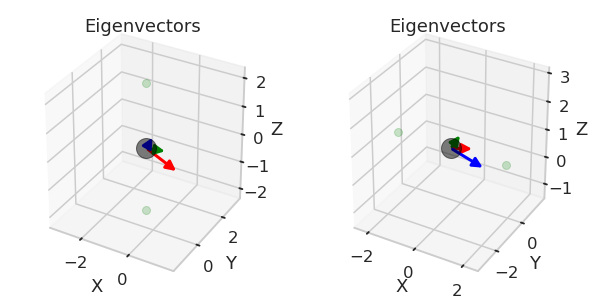

In [18]:
nb_vec = debugmode.nb_vec
eig_vec = debugmode.eig_vec
transformed = debugmode.transformed
transformed_eigvec = debugmode.transformed_eigvec



##################################################################################
if debugmode.plot_eigenvector:
    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')

    ax1 = plt_eig(ax1, nb_vec, eig_vec, 'Eigenvectors')
    ax2 = plt_eig(ax2, transformed, transformed_eigvec, 'Eigenvectors')

    plt.show()
